# Exercise #4: Physical properties of zeolites

In this exercise, we are going to use molecular dynamics (MD) to probe the physical properties of nanoporous materials. We will study the thermal and mechanical properties of a family of materials called zeolites.

[Zeolites](https://en.wikipedia.org/wiki/Zeolite) are nanoporous crystalline aluminosilicate frameworks. We will focus here on a subset of these materials, containing only silicon and oxygen atoms. These “pure-silica zeolites” have a topology of SiO₂. They are [polymorphs of α-quartz](https://en.wikipedia.org/wiki/Silicon_dioxide) and can take many geometries: you can explore the 242 known topologies of zeolites in the `zeolites/` folder.

In [1]:
%%bash
[[ -z "$COLAB_RELEASE_TAG" ]] && exit
# Install required packages if running on Google Colab
pip install ase mdanalysis nglview openmm tidynamics

In [2]:
from io import StringIO
import tempfile
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

from ase.io import read

import MDAnalysis as mda
import MDAnalysis.analysis.rdf, MDAnalysis.analysis.msd

import nglview

import openmm
import openmm.app
import openmm.unit

try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False

Let's have a look at one zeolite in particular, called [faujasite](https://en.wikipedia.org/wiki/Faujasite). In nature it's a rare mineral, but it's widely synthesized industrially and used for processus of ion exchange, separation of gases, heterogeneous catalysis, etc. All zeolite topologies are identified by a three-letter code, and faujasite is “FAU”. We can load its structure and view it:

In [3]:
fau = read("zeolites/FAU.cif")
view = nglview.show_ase(fau)
view.camera = 'orthographic'
view.add_unitcell()
view

/Users/fx/miniforge3/envs/ML2025b/lib/python3.12/site-packages/ase/io/cif.py:410: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(227, setting=1). This may result in wrong setting!
  warnings.warn(


NGLWidget()

As always, [xkcd](https://xkcd.com/) is relevant:

![xkcd on silicate chemistry](https://imgs.xkcd.com/comics/average_familiarity.png)

Source: https://xkcd.com/2501/

## Calculation of thermal expansion

OK, let's do some molecular simulations. We define some functions to help with that.

In [4]:
class ExtendedStateDataReporter(openmm.app.StateDataReporter):
    """
    An extension of OpenMM's StateDataReporter_ class, which also outputs pressure if a barostat is present
    """
    # Inspired by https://atomsmm.readthedocs.io/en/latest/_modules/atomsmm/reporters.html#ExtendedStateDataReporter
    # See also https://github.com/openmm/openmm/issues/5129
    def __init__(self, file, reportInterval, **kwargs):
        self._barostat = kwargs.pop('barostat', None)
        super().__init__(file, reportInterval, **kwargs)

    def _constructHeaders(self):
        headers = super()._constructHeaders()
        if self._barostat:
            headers.append('Pressure (atm)')
        return headers

    def _constructReportValues(self, simulation, state):
        values = super()._constructReportValues(simulation, state)
        if self._barostat:
            pressure = self._barostat.computeCurrentPressure(simulation.context)
            values.append(pressure.value_in_unit(openmm.unit.atmospheres))
        return values

The force field we use here is known as the “modified BKS” force field, from van Beest, Kramer and van Santen. It has the form of a Coulomb + Buckingham potential:
$$
U_{ij} = \frac{1}{4\pi\varepsilon_0} \frac{q_i q_j}{r_{ij}} + A_{ij}\exp(-B_{ij}\, r_{ij}) - \frac{C_{ij}}{r_{ij}^6} + \frac{D_{ij}}{r_{ij}^{24}}
$$

It combines Coulombic interactions (determined by partial atomic charges), exponential repulsive interactions, dispersive interactions in $r^{-6}$, and an extra short-term repulsive potential in $r^{-24}$. Sources for this potential and its various coefficients:
- Original BKS paper, with only the first three terms: https://doi.org/10.1103/PhysRevLett.64.1955
- Addition of the extra $r^{-24}$ term, for stability at high pressure: https://doi.org/10.1016/j.commatsci.2016.07.041

How many independent parameters are needed for that force field?
- $q_{\text{Si}}$ (because $q_{\text{O}}$ is imposed from $q_{\text{Si}}$ by electroneutrality)
- $A$, $B$, $C$ and $D$ for Si–Si, Si–O and O–O interactions

So that's 13 parameters in total. But the chemistry of silica and silicates has been very widely studied, so values of all these parameters are available (see the two references above).

In [5]:
offxml = """
<ForceField>
<AtomTypes>
 <Type name="0" class="Si" element="Si" mass="28.0855"/>
 <Type name="1" class="O" element="O" mass="15.9994"/>
</AtomTypes>

<Residues>
 <Residue name="Si">
  <Atom name="Si" type="0"/>
 </Residue>
 <Residue name="O">
  <Atom name="O" type="1"/>
 </Residue>
</Residues>

<CustomNonbondedForce energy="96.485 * (acoef*exp(-bcoef*(10*r)) - ccoef/(10*r)^6 + dcoef/(10*r)^24);
  acoef = (18003.757 * pairSiO + 1388.7730 * pairOO);
  bcoef = (4.87318 * pairSiO + 2.76000 * pairOO);
  ccoef = (133.5381 * pairSiO + 175.0000 * pairOO);
  dcoef = (29.0 * pairSiO + 113.0 * pairOO + 3423200. * pairSiSi);
  pairOO = IsO1*IsO2; pairSiSi = (1-IsSi1)*(1-IsSi2); pairSiO = (1-IsSi1)*IsSi2 + (1-IsSi2)*IsSi1;
  " bondCutoff="3">
 <PerParticleParameter name="IsO"/>
 <PerParticleParameter name="IsSi"/>
 <Atom type="0" IsO="0" IsSi="1"/>
 <Atom type="1" IsO="1" IsSi="0"/>
</CustomNonbondedForce>

<NonbondedForce coulomb14scale="0." lj14scale="0.">
 <Atom type="0" charge="2.4" sigma="0.2" epsilon="0."/>
 <Atom type="1" charge="-1.2" sigma="0.2" epsilon="0."/>
</NonbondedForce>
</ForceField>
"""

# We use a CustomNonbondedForce for the Buckingham part of the potential, and
# a NonbondedForce with epsilon == 0 for the Coulombic part.
#
# 96.485 is the conversion factor from eV to kJ/mol
# 
# Note to self: using the 1/r^24 term in this force field was a bit tricky, because it can underflow
# and cause trouble. For details, see https://github.com/openmm/openmm/issues/5136
# This is why r is converted from nm to Å in the formula itself, to avoid having big powers
# of very small numbers. That makes the force field more stable on GPU (such as OpenCL).

forcefield = openmm.app.forcefield.ForceField(StringIO(offxml))

As we did before, we will wrap the entirely simulation in a single function. It takes as input a zeolite structure file (in CIF format), and performs MD in the $(N, P, T)$ ensemble starting from that structure. It outputs the data and trajectory.

In [6]:
def perform_NPT_MD_on_zeolite(zeolite, temperature, pressure, nsteps,
                    timestep = 0.002 * openmm.unit.picoseconds,
                    friction = 1. / openmm.unit.picoseconds,
                    report_frequency = 50):
    """
    Perform a MD simulation of zeolite based on its structure (as CIF file).
    The MD is performed in the NPT ensemble, at specific temperature and pressure.
    Return the data and trajectory.
    """

    # Read the zeolite structure
    with warnings.catch_warnings():
        # Ignore "crystal system 'cubic' is not interpreted for space group Spacegroup(227, setting=1). This may result in wrong setting!"
        warnings.filterwarnings("ignore", category=UserWarning)
        zeo_struct = read(zeolite)

    # Create the topology from the zeolite structure
    topology = openmm.app.Topology()
    chain = topology.addChain('SiO2')
    angstrom_to_nm = 0.1
    topology.setPeriodicBoxVectors([zeo_struct.cell.array[0] * angstrom_to_nm,
                                    zeo_struct.cell.array[1] * angstrom_to_nm, 
                                    zeo_struct.cell.array[2] * angstrom_to_nm])
    for atom in zeo_struct:
        res = topology.addResidue('MOL', chain)
        topology.addAtom(atom.symbol, openmm.app.element.Element.getByAtomicNumber(atom.number), res)

    # Apply the force field to create a system
    system = forcefield.createSystem(topology, nonbondedMethod=openmm.app.CutoffPeriodic, nonbondedCutoff=1.1)
    
    barostat = None
    barostat = openmm.MonteCarloBarostat(pressure, temperature)
    system.addForce(barostat)
    
    integrator = openmm.LangevinMiddleIntegrator(temperature, friction, timestep)
    simulation = openmm.app.Simulation(topology, system, integrator)
    
    simulation.context.setPositions(fau.positions * openmm.unit.angstrom)
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperature)

    # Output data to temporary files
    with tempfile.TemporaryDirectory() as tmpdir:
        # Write initial configuration in PDB format
        openmm.app.pdbfile.PDBFile.writeFile(topology, fau.positions * openmm.unit.angstrom, f'{tmpdir}/md_first.pdb')

        # Write trajectory
        dcd_reporter = openmm.app.DCDReporter(f'{tmpdir}/md_trajectory.dcd', report_frequency, enforcePeriodicBox=False)
        simulation.reporters.append(dcd_reporter)

        # Output numerical data
        data_reporter = ExtendedStateDataReporter(f'{tmpdir}/md_data.csv', report_frequency,
            step=True, time=True, potentialEnergy=True, kineticEnergy=True,
            volume=True, temperature=True, density=True, barostat=barostat,
        )
        simulation.reporters.append(data_reporter)

        # Run the simulation
        simulation.step(nsteps)

        # Terminate the simulation, close output files (needed on Windows)
        del simulation
        del dcd_reporter
        del data_reporter

        # Gather the numerical data
        data = pd.read_csv(f'{tmpdir}/md_data.csv')

        # Read the trajectory
        with warnings.catch_warnings():
            # Ignore "DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace"
            warnings.filterwarnings("ignore", category=DeprecationWarning)
            traj = mda.Universe(f'{tmpdir}/md_first.pdb', f'{tmpdir}/md_trajectory.dcd')
            # Trajectory file will soon be removed, so we must force the trajectory in memory
            traj.transfer_to_memory()

        # Return data and trajectory
        return data, traj

Let's check that this function works.

In [7]:
%%time
d, t = perform_NPT_MD_on_zeolite("zeolites/FAU.cif", 300. * openmm.unit.kelvin, 1. * openmm.unit.bar, 20000)

CPU times: user 971 ms, sys: 685 ms, total: 1.66 s
Wall time: 3.46 s


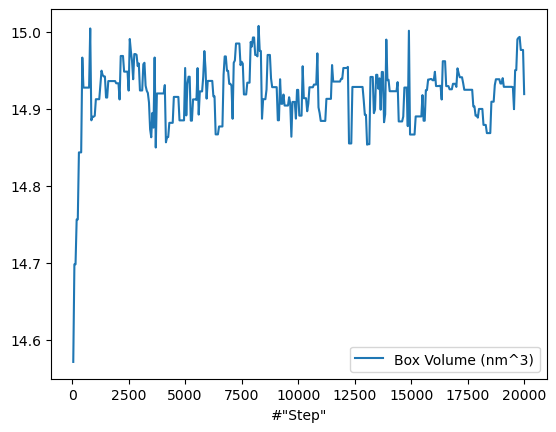

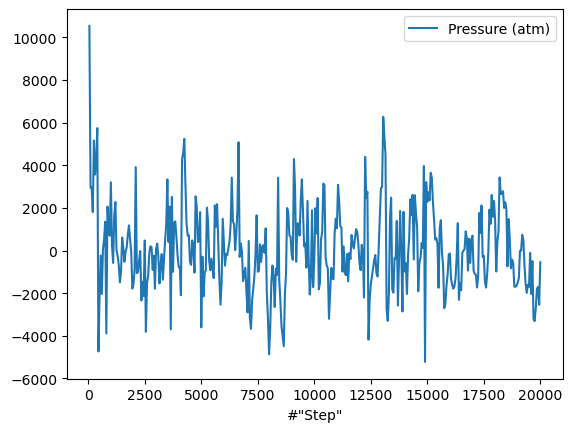

In [8]:
d.plot(x='#"Step"', y='Box Volume (nm^3)')
d.plot(x='#"Step"', y='Pressure (atm)');

## Part A: Mechanical properties

In the $(N, P, T)$ ensemble, we can run simulations of our system as a function of pressure and temperature, and determine all other thermodynamic quantities, including volume $V$, internal energy $U$, etc.

One key mechanical property of a solid is its [bulk modulus](https://en.wikipedia.org/wiki/Bulk_modulus), which characterizes the resistance of the material to compression, when a homogeneous pressure is applied from all sides. The bulk modulus $K$ is defined as:

$$ K = -V \left(\frac{\partial P}{\partial V}\right)_{N,T} $$

Use constant-pressure molecular dynamics simulations in order to determine the bulk modulus of faujasite.

## Part B: Thermal expansion

The response of a material to changes in temperature is typically characterized by its $V(T)$ curve, or equivalently by the evolution of its density $\rho(T)$. In specific ranges of temperature, if the behavior is linear, one can define a [coefficient of thermal expansion](https://en.wikipedia.org/wiki/Thermal_expansion) as:

$$ \alpha_V = \frac{1}{V} \left(\frac{\partial V}{\partial T}\right)_{N,P} $$

Characterize the thermal response of faujasite in the range of 50 to 950 K. What can you say about the sign of its thermal expansion?

## Part C: Anisotropic mechanical properties

The structure of crystals is anisotropic, i.e., not all directions of space are the same. Therefore, the mechanical properties of crystals are also anisotropic, meaning that the elastic stiffness of a crystal will differ depending on the direction in which the mechanical constraint is applied.

The [Young’s modulus](https://en.wikipedia.org/wiki/Young%27s_modulus) is one of the characterizations of anisotropic linear elastic response. It quantities the response for an axial tension or compression.

Can you think of a way to measure the Young’s modulus of faujasite?